In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import xarray as xr
import random 
import numpy as np
from pathlib import Path 
import glob

from sklearn.metrics import mean_squared_error

import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

# Eurac utils
#ImportError: cannot import name 'apply_missing_policy' from 'hython.preprocess' 
from hython.preprocess import preprocess, apply_normalization
from hython.models.lstm import CustomLSTM, CudnnLSTM
from hython.metrics import mse_metric
from hython.losses import RMSELoss
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.viz import plot_sampler
from hython.sampler import RegularIntervalSampler
from hython.utils import missing_location_idx, reconstruct_from_missing

# visualize 
import matplotlib.pyplot as plt
import geopandas as gpd
from cartopy import crs as ccrs

import warnings
warnings.filterwarnings("ignore")

In [4]:
import hython 


In [5]:
pip show hython 

Name: hython
Version: 0.0.1
Summary: 
Home-page: 
Author: 
Author-email: Mohammad Alasawedah <mohammadhussein.alasawedah@eurac.edu>, Iacopo Ferrario <iacopofederico.ferrario@eurac.edu>
License: 
Location: /home/malasawedah/.conda/envs/gpu_env/lib/python3.11/site-packages
Editable project location: /home/malasawedah/intertwin-hython/hython
Requires: numpy, torch, xarray
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [6]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(2023)

In [7]:
## user settings

domain = "alps" # "alps"

timeslice = slice("2016-01-01","2020-12-31")


dynamic_names = ["precip", "pet", "temp"]
static_names = [ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'] 
target_names = [ "vwc","actevap" ] # "q_river"]




In [8]:
if domain == "alps":
    ipath = Path('/mnt/CEPH_PROJECTS/InterTwin/Wflow/full_domain/alps1km')
    dyn_vars_ds = xr.open_dataset(ipath / 'inmaps_eobs_eobsd_makkink_86400_2015_2019.nc', decode_coords='all',chunks= {"time":100})
    static_params_ds = xr.open_dataset(ipath / "staticmaps.nc", decode_coords='all', chunks= {"time":100}).sel(layer=1)
    target_ds = xr.open_dataset(ipath / "run_default/output.nc", decode_coords='all', chunks= {"time":100}).sel(layer=1).isel(lat=slice(None, None, -1))
    target_ds.dims,dyn_vars_ds.dims, static_params_ds.dims
if domain == "adige":
    glob.glob('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data')
    dyn_vars_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/Dynamic_Data_2000_2015.nc',decode_coords='all', chunks= {"time":100})#.to_dataset(dim='variable')
    static_params_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/staticmaps.nc',decode_coords='all', chunks= {"time":100}).sel(layer=1)#.to_dataset(dim='variable')
    target_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/Target_train_et_sm_2000_2015.nc',decode_coords='all', chunks= {"time":100}).isel(lat=slice(None, None, -1))
    dyn_vars_ds.dims, static_params_ds.dims, target_ds.dims

In [9]:
target_ds.data_vars, dyn_vars_ds.data_vars, static_params_ds.data_vars;

In [10]:
target_ds

<xarray.Dataset>
Dimensions:  (lon: 1177, lat: 689, time: 1825)
Coordinates:
  * lon      (lon) float64 5.079 5.088 5.098 5.107 ... 15.83 15.84 15.85 15.86
  * lat      (lat) float64 50.03 50.02 50.01 50.0 ... 43.75 43.74 43.73 43.72
    layer    float64 1.0
  * time     (time) datetime64[ns] 2015-01-02 2015-01-03 ... 2019-12-31
Data variables:
    actevap  (time, lat, lon) float32 dask.array<chunksize=(100, 689, 1177), meta=np.ndarray>
    q_river  (time, lat, lon) float32 dask.array<chunksize=(100, 689, 1177), meta=np.ndarray>
    vwc      (time, lat, lon) float32 dask.array<chunksize=(100, 344, 589), meta=np.ndarray>

## Preparation

In [11]:
if timeslice:

    dyn_vars_ds = dyn_vars_ds.sel(time=timeslice)
    target_ds = target_ds.sel(time=timeslice)
    target_ds.dims,dyn_vars_ds.dims

In [12]:
mask_lakes = (target_ds.mean(dim = "time")["actevap"] == 0).astype(np.bool_)

In [13]:
dim_space = list(dyn_vars_ds.dims.values())[1:] # lon, lat
dim_time = list(dyn_vars_ds.dims.values())[0] # tim
dim_space, dim_time

([1177, 689], 1461)

In [14]:
!ls /mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/temp/

grid_0_0_0.npz	 grid_10_0_5.npz   grid_30_0_15.npz
grid_10_0_3.npz  grid_20_0_10.npz  grid_30_0_3.npz


In [15]:
intervals = (10, 10)
train_origin = (0, 0)
valid_origin =  (3, 3)
test_origin =  (9, 9)

compute = False
save = False

### Preprocess

In [16]:
# mask lakes
remove_lakes = True
if remove_lakes:
    target_ds = target_ds.where(~mask_lakes, np.nan)
    dyn_vars_ds = dyn_vars_ds.where(~mask_lakes, np.nan)
    static_params_ds = static_params_ds.where(~mask_lakes, np.nan)

#

In [17]:
if compute: 
    Xd, Xs, Y, dims, meta = preprocess(dyn_vars_ds, 
                       static_params_ds, 
                       target_ds, 
                       dynamic_name = dynamic_names,
                       static_name = static_names, 
                       target_name = target_names, 
                       sampler = Sampler(intervals = intervals,
                                         origin = train_origin),
                        return_sampler_meta = True
                       )
    Xd_valid, Xs_valid, Y_valid, dims_valid, meta_valid = preprocess(dyn_vars_ds, 
                       static_params_ds, 
                       target_ds, 
                       dynamic_name = dynamic_names,
                       static_name = static_names, 
                       target_name = target_names, 
                       sampler = Sampler(intervals = intervals,
                                         origin = valid_origin),
                      return_sampler_meta = True
                       )
else:
    loaded = np.load(f'/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/temp/grid_{intervals[0]}_{train_origin[0]}_{valid_origin[0]}.npz',
                    allow_pickle=True)
    for ff in loaded.files:
        print(ff)
        if "dims" in ff:
            exec(f"{ff}=loaded['{ff}'].tolist()")
        else:
            exec(f"{ff}=loaded['{ff}']")

Xd
Xs
Y
dims
Xd_valid
Xs_valid
Y_valid
dims_valid
meta
meta_valid


In [18]:
if save:
    np.savez_compressed(f'/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/temp/grid_{intervals[0]}_{train_origin[0]}_{valid_origin[0]}'
                    , Xd=Xd, Xs=Xs, Y=Y, dims=dims, Xd_valid=Xd_valid, Xs_valid=Xs_valid,
                       Y_valid=Y_valid, dims_valid=dims_valid, meta=meta, meta_valid=meta_valid)

In [19]:
# Xd_test, Xs_test, Y_test, dims_test = preprocess(dyn_vars_ds, 
#                        static_params_ds, 
#                        target_ds, 
#                        dynamic_name = dynamic_names,
#                        static_name = static_names, 
#                        target_name = target_names, 
#                        sampler = Sampler(intervals = intervals,
#                                          origin = test_origin)
#                        )

In [20]:
#plot_sampler(static_params_ds.wflow_dem, meta, meta_valid)

### Correct negative values in actevap 

In [21]:
if (Y < 0).any():
    print("found negative values")
    Y = np.where(Y < 0, 0, Y)

In [22]:
# Y = Y[:,:,[0]]

In [23]:
# Y_valid = Y_valid[:,:,[0]]

### Remove missing

In [24]:
Y.shape

(8142, 1461, 2)

In [25]:
# find indices of missing values
idx = missing_location_idx(Xs)

In [26]:
# find indices of missing values
idx_valid = missing_location_idx(Xs_valid)

In [27]:
Xd_clean = Xd[~idx]
Xs_clean = Xs[~idx]
Y_clean = Y[~idx]

Xd_valid_clean = Xd_valid[~idx_valid]
Xs_valid_clean = Xs_valid[~idx_valid]
Y_valid_clean = Y_valid[~idx_valid]

In [28]:
Xd.shape, Xd_clean.shape, Xs_clean.shape, Y_clean.shape

((8142, 1461, 3), (3723, 1461, 3), (3723, 8), (3723, 1461, 2))

In [29]:
np.isnan(Xd_clean).any(), np.isnan(Xs_clean).any(), np.isnan(Y_clean).any(),np.isnan(Xd_valid_clean).any(), np.isnan(Xs_valid_clean).any(), np.isnan(Y_valid_clean).any()

(False, False, False, False, False, False)

### Normalization

In [30]:
Xd_clean, d_m, d_std = apply_normalization(Xd_clean, type = "spacetime", how ='standard')
Xs_clean, s_m, s_std = apply_normalization(Xs_clean, type = "space", how ='standard')

In [31]:
Y_clean, y_m1, y_m2 = apply_normalization(Y_clean, type = "spacetime", how ='minmax')

In [32]:
s_std.shape,d_std.shape,y_m1.shape

((8,), (3,), (2,))

In [33]:
Xd_valid_clean = apply_normalization(Xd_valid_clean, type = "spacetime", how ='standard', m1 = d_m, m2 = d_std)
Xs_valid_clean = apply_normalization(Xs_valid_clean, type = "space", how ='standard', m1 = s_m, m2 = s_std)

In [34]:
Y_valid_clean = apply_normalization(Y_valid_clean, type = "spacetime", how ='minmax', m1 = y_m1, m2 = y_m2)

In [35]:
np.isnan(Xd_clean).any(), np.isnan(Xs_clean).any(), np.isnan(Y_clean).any(),np.isnan(Xd_valid_clean).any(), np.isnan(Xs_valid_clean).any(), np.isnan(Y_valid_clean).any()

(False, False, False, False, False, False)

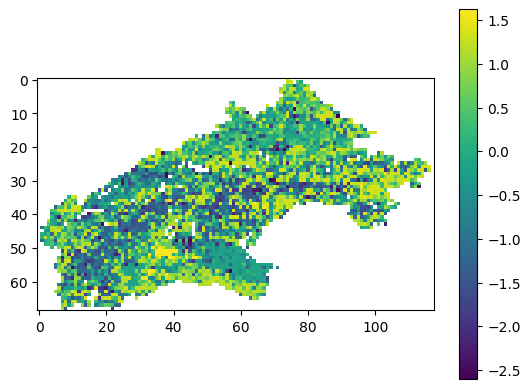

In [36]:
plt.imshow(reconstruct_from_missing(Xs_clean, Xs.shape, idx)[:,2].reshape(*dims["sampled_dims"][:2]))
plt.colorbar()

In [37]:
Xs_clean = torch.Tensor(Xs_clean)
Xs_valid_clean = torch.Tensor(Xs_valid_clean)

Xd_clean = torch.Tensor(Xd_clean)
Xd_valid_clean = torch.Tensor(Xd_valid_clean)

Y_clean = torch.Tensor(Y_clean)
Y_valid_clean = torch.Tensor(Y_valid_clean)

### Preparing data loader

In [38]:
nx = Xd.shape[-1] + Xs.shape[-1]
ny = Y.shape[-1]
nx, ny

(11, 2)

In [39]:

spatial_batch_size =  256 # int(512 / 4)
temporal_sampling_size = 130
seq_length = 360


In [40]:
train_dataset = LSTMDataset(Xd_clean, Y_clean, Xs_clean, create_seq=False)

In [41]:
val_dataset = LSTMDataset(Xd_valid_clean, Y_valid_clean, Xs_valid_clean, create_seq=False)

In [42]:
# PyTorch DataLoader
#data_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=spatial_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=spatial_batch_size, shuffle=False)

In [43]:
# Invistigate the dataset 
for x1, x2, y in train_loader:
    print(x1.shape, x1.dtype)
    print(x2.shape, x2.dtype)
    print(y.shape, y.dtype)
    break

torch.Size([256, 1461, 3]) torch.float32
torch.Size([256, 8]) torch.float32
torch.Size([256, 1461, 2]) torch.float32


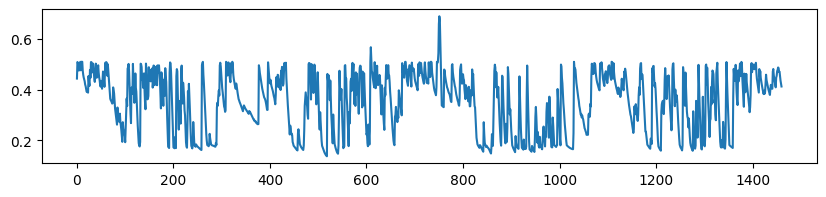

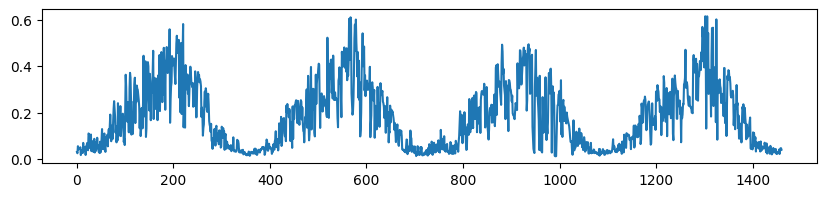

In [44]:
plt.figure(figsize= (10, 2))
plt.plot(y[12, :, 0])
plt.figure(figsize= (10, 2))
plt.plot(y[12, :, 1])

### Setting up model

In [45]:
experiment_name = "multi1"

hidden_size = 256

model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": hidden_size, # user_input
    "output_size": Y.shape[-1], # number_target - user_input
    "number_static_predictors": len(static_names), #number of static parameters - user_input 

}

## The used device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_params

{'input_size': 3,
 'hidden_size': 256,
 'output_size': 2,
 'number_static_predictors': 8}

In [46]:
model = CustomLSTM(model_params)
#model = CudnnLstmModel(nx = nx, ny =  ny, hiddenSize =  hidden_size)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=11, out_features=256, bias=True)
  (lstm): LSTM(256, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

#### Metrics

In [181]:
set_seed(2023)

target_names = ['sm', 'evp']

# Training and validation 
path2models= "./checkpoints" 
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = RMSELoss(target_weight={'sm':0.5, 'actevap':0.5}) 

## Set the metric function - here using MSE
metric_fn = mse_metric 

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

In [192]:

epochs = 100

## Set the training parameters
params_train={
    "num_epochs": epochs,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "target_names": target_names,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/{experiment_name}-weights.pt",
    "device":device

}


type(model)

hython.models.lstm.CustomLSTM

In [193]:
model

CustomLSTM(
  (fc0): Linear(in_features=11, out_features=256, bias=True)
  (lstm): LSTM(256, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

## Running

In [ ]:
model, loss_history , metric_history = train_val(model, params_train)

Epoch 0/99, current lr=0.01
Copied best model weights!
train loss: 0.05214013531804085, train metric: {'sm': 0.0038412586, 'evp': 0.0027002336}
val loss: 0.1676795333623886, val metric: {'sm': 0.035429772, 'evp': 0.027194526}
----------
Epoch 1/99, current lr=0.01
train loss: 0.05298939347267151, train metric: {'sm': 0.0039600357, 'evp': 0.0027582117}
val loss: 0.18703573942184448, val metric: {'sm': 0.043796014, 'evp': 0.03522408}
----------
Epoch 2/99, current lr=0.01
train loss: 0.05458671599626541, train metric: {'sm': 0.0043851472, 'evp': 0.0028453195}
val loss: 0.2635686695575714, val metric: {'sm': 0.0888811, 'evp': 0.06578263}
----------
Epoch 3/99, current lr=0.01
train loss: 0.0527535155415535, train metric: {'sm': 0.0041092355, 'evp': 0.0027988607}
val loss: 0.190193772315979, val metric: {'sm': 0.025885684, 'evp': 0.058075167}
----------
Epoch 4/99, current lr=0.01
train loss: 0.050383687019348145, train metric: {'sm': 0.0040164436, 'evp': 0.0021763267}
val loss: 0.16978870

In [189]:
metric_history

{'train_sm': [0.0038074162, 0.004052971],
 'train_evp': [0.0028472876, 0.001913318],
 'val_sm': [0.05380281, 0.062042482],
 'val_evp': [0.024367232, 0.03940458]}

### SM plotting

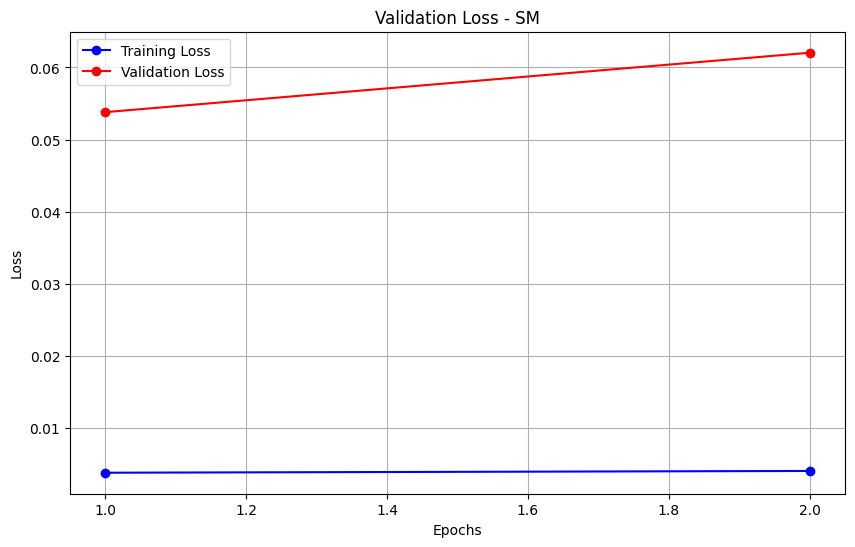

In [190]:
# import matplotlib.pyplot as plt
# Extract the loss values
train_loss = metric_history['train_sm']
val_loss = metric_history['val_sm']

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
lepochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(lepochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(lepochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### EVP plotting

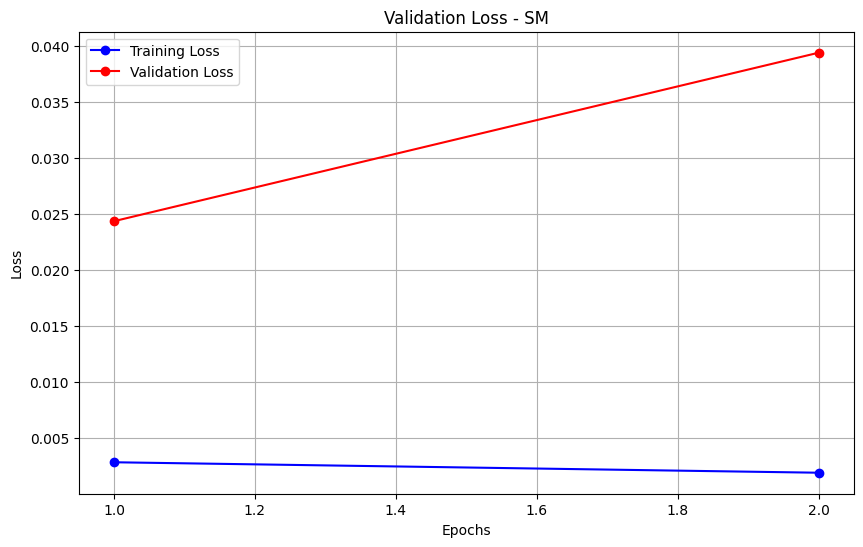

In [191]:
# import matplotlib.pyplot as plt
# Extract the loss values
train_loss = metric_history['train_evp']
val_loss = metric_history['val_evp']

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
lepochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(lepochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(lepochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()